In [1]:
import os
import sys
from pathlib import Path

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import trackpy as tp
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


from tqdm import tqdm
from pathlib import Path
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
from skimage.measure import regionprops
from scipy.spatial import Delaunay

sys.path.append("code/preprocessing/utils/")
from segment2D     import *
from segment3D     import *
from file_handling import *

sys.path.append("code/preprocessing/src/")
from ImUtils import commonStackReader

sys.path.append("code/analysis/utils/")

from data_class import SegmentationData, VariationData, AutocorrelationData
from variation_functions import spatial_variation, global_density

pix_to_um = get_pixel_size()

In [9]:
dataset = "tomocube_20250904_B1"
#dataset = "holomonitor_20240301_B1-4"

config  = json.load(open(f"data/experimental/configs/{dataset}.json"))
#microscope = Path(dataset).stem.split("_")[0]

In [10]:
# load data
#im_cell_areas = np.load(f"data/experimental/processed/{dataset}/im_cell_areas_raw.npy")
#dims = np.shape(im_cell_areas)
h_stack = import_stack(f"data/experimental/raw/test/heights/{dataset}/", config)

#cellprop = SegmentationData(f"data/experimental/processed/{dataset}/cell_props.p")

# cellcorr  = AutocorrelationData(f"data/experimental/processed/{dataset}/cell_autocorr.p")

#fieldcorr = AutocorrelationData(f"data/experimental/processed/{dataset}/field_autocorr.p")
# df     = pd.read_csv(f"data/experimental/processed/{dataset}/dataframe_unfiltered.csv")

# print("cell:",  cellcorr.log)
#print("field:", fieldcorr.log)


FileNotFoundError: No such file: '/home/silja/Documents/MDCK_QPI/data/experimental/raw/test/heights/tomocube_20250904_B1/MDCK-li_height_0.tiff'

In [102]:
x = np.ma.array((cellprop.x[:-1] + cellprop.x[1:]) / (2 * pix_to_um[1]), dtype=np.uint8)
y = np.ma.array((cellprop.y[:-1] + cellprop.y[1:]) / (2 * pix_to_um[1]), dtype=np.uint8)

u = np.zeros([len(x), dims[1]+10, dims[2]+10], dtype=np.uint64)
v = np.zeros([len(x), dims[1]+10, dims[2]+10], dtype=float)

for i in range(len(x)):
    x_idx = x[i].compressed()
    y_idx = y[i].compressed()

    u[i, x_idx, y_idx] = np.copy(cellprop.dx[i].compressed())
    v[i, x_idx, y_idx] = np.copy(cellprop.dy[i].compressed())

/home/silja/Documents/MDCK_QPI/mdck_venv/lib/python3.12/site-packages/numpy/ma/core.py:509: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/home/silja/Documents/MDCK_QPI/mdck_venv/lib/python3.12/site-packages/numpy/ma/core.py:2896: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


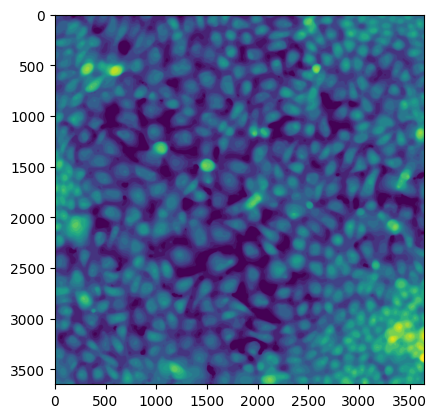

In [6]:
plt.imshow(h_stack[0])

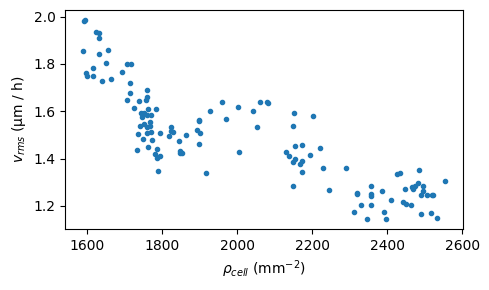

In [44]:
v_rms  = np.ma.sqrt(np.ma.mean(cellprop.dx**2 + cellprop.dy**2, axis=1)) #* 12
v_mean = np.ma.mean(np.ma.sqrt(cellprop.dx**2 + cellprop.dy**2), axis=1) #* 12

density = global_density(cellprop.A)[:-1]
frames = np.arange(len(v_rms)) / 12

plt.figure(figsize=(5,3))
plt.plot(density, v_rms, '.')
plt.xlabel(r"$\rho_{cell}$ (mm$^{-2}$)")
plt.ylabel(r"$v_{rms}$ (µm / h)")
plt.tight_layout()
plt.savefig(f"results/{dataset}/rms_velocity.png", dpi=300)

In [4]:
cellprops = [regionprops(im_cell_areas[i], h_stack[i]) for i in range(len(im_cell_areas))]

In [5]:
positions = np.concatenate([[cell.centroid_weighted for cell in cellprop] for cellprop in cellprops])
frames = np.concatenate([[frame for cell in cellprops[frame]] for frame in range(len(cellprops))])
labels = np.concatenate([[cell.label for cell in cellprop] for cellprop in cellprops])

In [6]:
cell_df = pd.DataFrame({'y': positions.T[0],
                        'x': positions.T[1],
                        'label': labels,
                        'frame': frames})

search_range = 20
tracks = tp.link(cell_df, search_range=search_range, memory=5);
tracks = tp.filter_stubs(tracks, threshold=5);

Frame 119: 542 trajectories present.


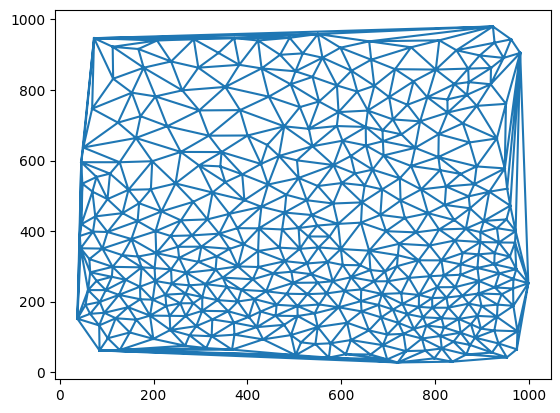

In [7]:
tri = Delaunay(positions[frames==0])
plt.triplot(positions[frames==0].T[1], positions[frames==0].T[0])

In [ ]:
def find_Delaunay_neighbours(cell_positions, cell_labels):

    # Perform Delaunay triangulation
    tri = Delaunay(cell_positions)

    # Go through cell indices and collect neighbours
    cell_neighbours = []
    for cell_idx in range(len(cell_positions)):

        label = cell_labels[cell_idx]

        # Find neighbors using Delaunay triangulation
        neighbors_idx = set()
        for simplex in tri.simplices:

            if cell_idx in simplex:

                neighbors_idx.update(simplex)

            # Remove target index
            neighbors_idx.discard(cell_idx)

            cell_neighbours.append([int(n_idx) for n_idx in neighbors_idx])

    return cell_neighbours

In [52]:
neighbors_matrix = np.zeros([np.max(frames), (np.max(tracks.particle)), (np.max(tracks.particle))])
np.shape(neighbors_matrix)

particle_id = tracks.particle.values
positions = np.array([tracks.y.values, tracks.x.values]).T
frames = tracks.frame.values

In [53]:
len(positions), len(particle_id)

(60962, 60962)

In [204]:
cell_positions = positions

for frame in tqdm(range(len(neighbors_matrix))):
    tri = Delaunay(cell_positions[frames == frame])

    for cell_idx in range(len(cell_positions[frames == frame])): 

        label = particle_id[frames == frame][cell_idx]

        # Find neighbors using Delaunay triangulation
        neighbors_idx = set()
        for simplex in tri.simplices:

            if cell_idx in simplex:
                neighbors_matrix[frame, label, particle_id[frames == frame][simplex]] = 1
                
                neighbors_idx.update(simplex)


 97%|█████████▋| 115/119 [03:17<00:06,  1.72s/it]


IndexError: index 1181 is out of bounds for axis 2 with size 1181

In [205]:
for i in range(len(neighbors_matrix[0])):
    neighbors_matrix[:, i,i] = 0

In [206]:
corr = np.zeros(len(neighbors_matrix))

for f in range(len(corr)):
    corr[f] = np.sum((neighbors_matrix * np.roll(neighbors_matrix, shift=-f, axis=0))[:-f])



In [210]:
corr[0] = np.sum(neighbors_matrix**2)

array([28.23081128])

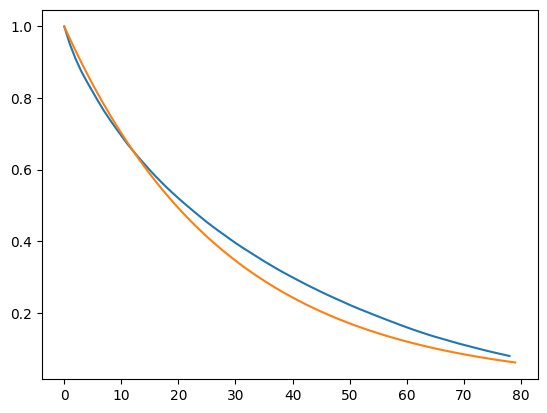

In [244]:
def decay_func(t, tau):
    return np.exp(-t/tau)

frame = 80

params, popt = curve_fit(decay_func, np.arange(frame), (corr / corr[0])[1:frame+1])

plt.plot((corr / corr[1])[1:frame])
plt.plot(np.arange(frame), decay_func(np.arange(frame), *params))
#plt.yscale("log")
# plt.plot(corr_norm[0])
params

In [169]:
corr[:,0]

array([2334., 2310., 2321., 2413., 2466., 2489., 2538., 2528., 2587.,
       2599., 2615., 2627., 2621., 2627., 2620., 2656., 2683., 2684.,
       2680., 2627.])

In [17]:
dataset = "tomocube_20250210_A2"
df = pd.read_csv(f"data/experimental/processed/{dataset}/dataframe_unfiltered.csv")

tracks = tp.link(df, search_range=50, memory=5)

Frame 39: 1009 trajectories present.


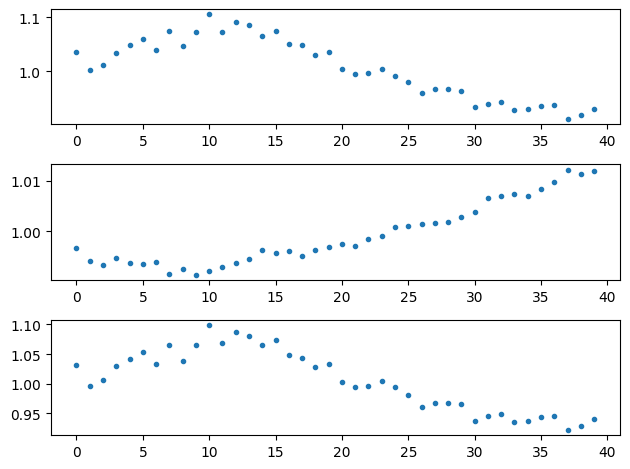

In [30]:
n = tracks.pivot(index='frame', columns='particle', values='n_avrg').to_numpy()
V = tracks.pivot(index='frame', columns='particle', values='V').to_numpy()

n = np.ma.masked_where(np.isnan(n), n)
V = np.ma.masked_where(np.isnan(V), V)


plt.subplot(311)
plt.plot(np.ma.mean(V, axis=1) / np.ma.mean(V), '.')


plt.subplot(312)
plt.plot(np.ma.mean(n-1.33, axis=1) / np.ma.mean((n-1.33)), '.')


plt.subplot(313)
plt.plot(np.ma.mean((n-1.33)*V, axis=1) / np.ma.mean((n-1.33)*V), '.')

plt.tight_layout()